In [1]:
""" Import Required Libraries"""
from tensorflow import keras
import cv2
from matplotlib import pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Prediction
In this section we will use the trained model on detecting the lower left third molar and test it on new unseen images.

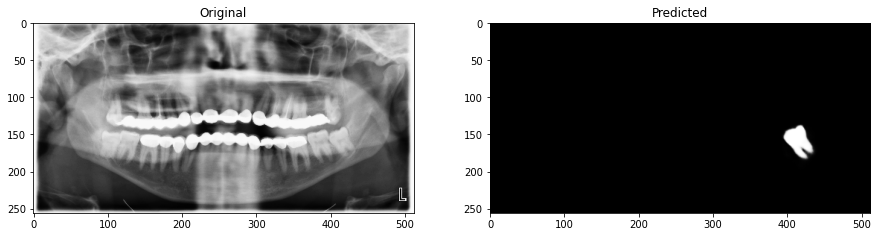

In [ ]:
""" 

U-Net Model  

"""

#Loaing model
model = keras.models.load_model('/content/saved_model_diffszie_512x256.h5', compile=False)

#Read a single image and perform image pre-processing
test_img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/GP/dataset/training_set/images/565-23-M-445506.jpg', cv2.IMREAD_GRAYSCALE) 
orig= test_img
orig = cv2.resize(test_img, (512, 256))      
test_img = cv2.resize(test_img, (512, 256))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BAYER_GR2GRAY)
test_img = np.expand_dims(test_img, axis=0)

#Make prediction
prediction = model.predict(test_img)

#View original image
plt.figure(figsize=(15, 18))
plt.subplot(1, 2, 1)
plt.imshow(orig, cmap='gray')
plt.title('Original')

#View predicted image
plt.subplot(1, 2, 2)
prediction_image = prediction.reshape(256, 512)
plt.imshow(prediction_image, cmap='gray')
plt.title('Predicted')

#Save predicted image to drive
plt.imsave('/content/drive/MyDrive/Colab_Notebooks/GP/dataset/predicted/565-23-M-445506.jpg', prediction_image, cmap='gray')


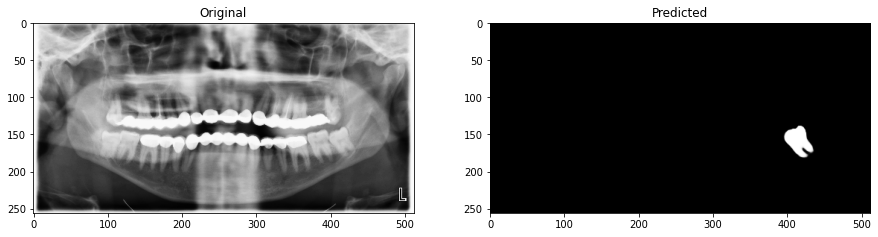

In [5]:
"""           

 Attention U-Net Model 

"""

model = keras.models.load_model('/content/3rdm_att_UNet_50epochs.h5', compile=False)

#Read a single image and perform image pre-processing
test_img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/GP/dataset/testing_set/images/565-23-M-445506.jpg', cv2.IMREAD_GRAYSCALE) 
orig= test_img
orig = cv2.resize(test_img, (512, 256))      
test_img = cv2.resize(test_img, (512, 256))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BAYER_GR2GRAY)
test_img = np.expand_dims(test_img, axis=0)

#Make prediction
prediction = model.predict(test_img)

#View original image
plt.figure(figsize=(15, 18))
plt.subplot(1, 2, 1)
plt.imshow(orig, cmap='gray')
plt.title('Original')

#View predicted image
plt.subplot(1, 2, 2)
prediction_image = prediction.reshape(256, 512)
plt.imshow(prediction_image, cmap='gray')
plt.title('Predicted')

#Save predicted image to drive
plt.imsave('/content/drive/MyDrive/Colab_Notebooks/GP/dataset/predicted/att_565-23-M-445506.jpg', prediction_image, cmap='gray')


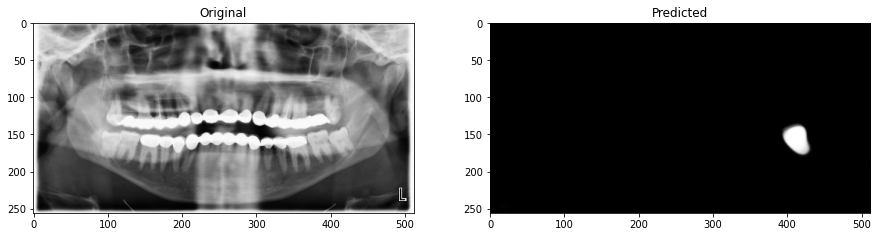

In [17]:
"""

 U-Net++ Model
 
"""

model = keras.models.load_model('/content/3rdm_UNet_plus_50epochs.h5', compile=False)

#Read a single image and perform image pre-processing
test_img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/GP/dataset/testing_set/images/565-23-M-445506.jpg', cv2.IMREAD_GRAYSCALE) 
orig= test_img
orig = cv2.resize(test_img, (512, 256))      
test_img = cv2.resize(test_img, (512, 256))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BAYER_GR2GRAY)
test_img = np.expand_dims(test_img, axis=0)

#Make prediction
prediction = model.predict(test_img)

#View original image
plt.figure(figsize=(15, 18))
plt.subplot(1, 2, 1)
plt.imshow(orig, cmap='gray')
plt.title('Original')

#View predicted image
plt.subplot(1, 2, 2)
prediction_image = prediction.reshape(256, 512)
plt.imshow(prediction_image, cmap='gray')
plt.title('Predicted')

#Save predicted image to drive
plt.imsave('/content/drive/MyDrive/Colab_Notebooks/GP/dataset/predicted/plus_565-23-M-445506.jpg', prediction_image, cmap='gray')

#Evaluation
In this section we will evaluate our semantic segmention model by applying diffrent measures: 



*   Accuracy
*   Dice Coefficient (F1 Score)
*   Jaccard index (IoU)
*   Sensitivty
*   Specificity
*   Precision












In [ ]:
""" 

U-Net Model  

"""

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512, 256))
    x = cv2.cvtColor(x, cv2.COLOR_BAYER_GR2GRAY)
    x = np.expand_dims(x, axis=0)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512, 256))
    x = cv2.cvtColor(x, cv2.COLOR_BAYER_GR2GRAY)
    x = x > 0.5
    x = np.expand_dims(x, axis=0)
    x = x.astype(np.int32)
    return x

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

if __name__ == "__main__":

    # Loading model 
    with CustomObjectScope({'iou': iou}):
        model = tf.keras.models.load_model("saved_model_diffszie_512x256.h5")

    # Loading the original images and segmentation map 
    test_x = sorted(glob("/content/testing_set/images/*"))
    test_y = sorted(glob("/content/testing_set/masks/*"))

    # Predicting the mask and calculating metrics values
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):

        #Extracing the image name
        image_name = x.split("/")[-1]

        # Reading the original image and segmentation map 
        x = read_image(x)
        y = read_mask(y)

        # Predicting the mask
        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

       # Flattening the numpy arrays, all measures requires to convert images to 1d array 
        y = y.flatten()
        y_pred = y_pred.flatten()

        # Calculating metrics values 
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value_sensitivty = recall_score(y, y_pred,pos_label=1 )#labels=[0, 1], average="binary"
        recall_value_specificity = recall_score(y, y_pred, pos_label=0)
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
        SCORE.append([image_name, acc_value, f1_value, jac_value, recall_value_sensitivty,recall_value_specificity, precision_value])

    # Metrics values 
    score = [s[1:]for s in SCORE]

    """Uncomment the measure you need: mean,median,std"""
    #score = np.mean(score, axis=0)
    #score = np.std(score, axis=0)
    #score = np.median(score, axis=0)

    print(f"\nAccuracy: {score[0]:0.5f}")
    print(f"Dice Coefficient: {score[1]:0.5f}")# F1
    print(f"Jaccard index: {score[2]:0.5f}")# iou
    print(f"Sensitivty: {score[3]:0.5f}") #Recall 
    print(f"Specificity: {score[4]:0.5f}")
    print(f"Precision: {score[5]:0.5f}")

    # Saving results of each image to a csv file 
    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Sensitivty","Specificity", "Precision"])
    df.to_csv("score.csv")

In [20]:
""" 

U-Net++ Model  
Attention U-Net Model

"""

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512, 256))
    x = cv2.cvtColor(x, cv2.COLOR_BAYER_GR2GRAY)
    x = np.expand_dims(x, axis=0)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512, 256))
    x = cv2.cvtColor(x, cv2.COLOR_BAYER_GR2GRAY)
    x = x > 0.5
    x = np.expand_dims(x, axis=0)
    x = x.astype(np.int32)
    return x

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

if __name__ == "__main__":

    # Loading model 
  with CustomObjectScope({'dice_coef': dice_coef}):
    """Uncomment the model you need to evaluate"""
    #model = tf.keras.models.load_model("3rdm_att_UNet_50epochs.h5")
    model = tf.keras.models.load_model("3rdm_UNet_plus_50epochs.h5")

    # Loading the original images and segmentation map 
    test_x = sorted(glob("/content/drive/MyDrive/Colab_Notebooks/GP/dataset/testing_set/images/*"))
    test_y = sorted(glob("/content/drive/MyDrive/Colab_Notebooks/GP/dataset/testing_set/segmentation_map/*"))

    # Predicting the mask and calculating metrics values
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):

        #Extracing the image name
      image_name = x.split("/")[-1]

        # Reading the original image and segmentation map 
      x = read_image(x)
      y = read_mask(y)

        # Predicting the mask
      y_pred = model.predict(x)[0] > 0.5
      y_pred = np.squeeze(y_pred, axis=-1)
      y_pred = y_pred.astype(np.int32)

       # Flattening the numpy arrays, all measures requires to convert images to 1d array 
      y = y.flatten()
      y_pred = y_pred.flatten()

        # Calculating metrics values 
      acc_value = accuracy_score(y, y_pred)
      f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
      jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
      recall_value_sensitivty = recall_score(y, y_pred,pos_label=1 )#labels=[0, 1], average="binary"
      recall_value_specificity = recall_score(y, y_pred, pos_label=0)
      precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary",zero_division=1)
      SCORE.append([image_name, acc_value, f1_value, jac_value, recall_value_sensitivty,recall_value_specificity, precision_value])

    # Metrics values 
      score = [s[1:]for s in SCORE]

    """Uncomment the measure you need: mean,median,std"""
    #score = np.mean(score, axis=0)
    #score = np.std(score, axis=0)
    score = np.median(score, axis=0)

    print(f"\nAccuracy: {score[0]:0.5f}")
    print(f"Dice Coefficient: {score[1]:0.5f}")# F1
    print(f"Jaccard index: {score[2]:0.5f}")# iou
    print(f"Sensitivty: {score[3]:0.5f}") #Recall 
    print(f"Specificity: {score[4]:0.5f}")
    print(f"Precision: {score[5]:0.5f}")

    # Saving results of each image to a csv file 
    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Sensitivty","Specificity", "Precision"])
    df.to_csv("score.csv")

100%|██████████| 218/218 [03:18<00:00,  1.10it/s]


Accuracy: 0.99844
Dice Coefficient: 0.86761
Jaccard index: 0.76617
Sensitivty: 0.86447
Specificity: 0.99936
Precision: 0.88448


#Support References:


*   https://www.youtube.com/watch?v=zLNkJqVZiiU
*   https://github.com/nikhilroxtomar/Evaluating-the-Semantic-Segmentation-Models/blob/main/eval.py
*   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html 



